<a href="https://colab.research.google.com/github/ybing86-lang/MSSP6070/blob/main/report4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import pandas as pd
import json
import numpy as np
from scipy import stats
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from shapely.geometry import shape, Polygon, MultiPolygon
import seaborn as sns
from datetime import datetime
from scipy.stats import ttest_ind
import io
import zipfile
import os

In [16]:
from google.colab import files
uploaded = files.upload()

Saving BRFSS2022_MentalHealth_Subset.csv to BRFSS2022_MentalHealth_Subset (1).csv


In [17]:
file_path = "BRFSS2022_MentalHealth_Subset.csv"
df_clean = pd.read_csv(file_path)
df_clean.shape

(445132, 15)

In [18]:
data_summary = df_clean.describe()
data_summary.round(2)

,MENTHLTH,_MENT14D,INCOME3,_INCOMG1,EMPLOY1,EDUCA,_HLTHPLN,PERSDOC3,MEDCOST1,_STATE,SEXVAR,_AGEG5YR,_RACEGR4,MARITAL,GENHLTH
count,427899.00,436065.00,239607.00,325607.00,296809.00,442749.00,427247.00,440757.00,443523.00,435348.0,445132.00,366977.00,431075.00,440330.00,443934.00
mean,4.33,1.53,6.35,4.24,2.32,5.04,1.05,1.57,1.92,31.5,1.53,7.67,1.65,2.35,2.57
std,8.46,0.72,2.74,1.52,2.24,1.01,0.23,0.71,0.28,16.5,0.50,4.01,1.29,1.70,1.05
min,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.00,1.00,1.00,1.00,1.00
25%,0.00,1.00,5.00,3.00,1.00,4.00,1.00,1.00,2.00,19.0,1.00,4.00,1.00,1.00,2.00
50%,0.00,1.00,6.00,5.00,1.00,5.00,1.00,1.00,2.00,30.0,2.00,8.00,1.00,1.00,3.00
75%,4.00,2.00,8.00,5.00,2.00,6.00,1.00,2.00,2.00,46.0,2.00,11.00,2.00,3.00,3.00
max,30.00,3.00,11.00,6.00,8.00,6.00,2.00,3.00,2.00,78.0,2.00,14.00,5.00,6.00,5.00


In [19]:
from google.colab import files
uploaded = files.upload()

Saving raw_data.csv to raw_data (1).csv


In [20]:
float_mean = df_clean["MENTHLTH"].mean()
float_sd = df_clean["MENTHLTH"].std()
print("unhealthy days (MENTHLTH)")
print(f"• Mean (Mean): {float_mean:.2f} days")
print(f"• SD (Standard deviation): {float_sd:.2f} days")

unhealthy days (MENTHLTH)
• Mean (Mean): 4.33 days
• SD (Standard deviation): 8.46 days


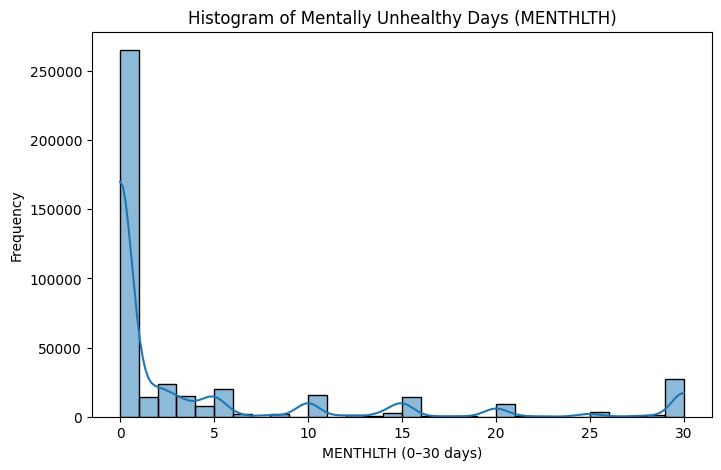

In [21]:
# Normality check
plt.figure(figsize=(8,5))
sns.histplot(df_clean["MENTHLTH"].dropna(), bins=30, kde=True)
plt.title("Histogram of Mentally Unhealthy Days (MENTHLTH)")
plt.xlabel("MENTHLTH (0–30 days)")
plt.ylabel("Frequency")
plt.show()

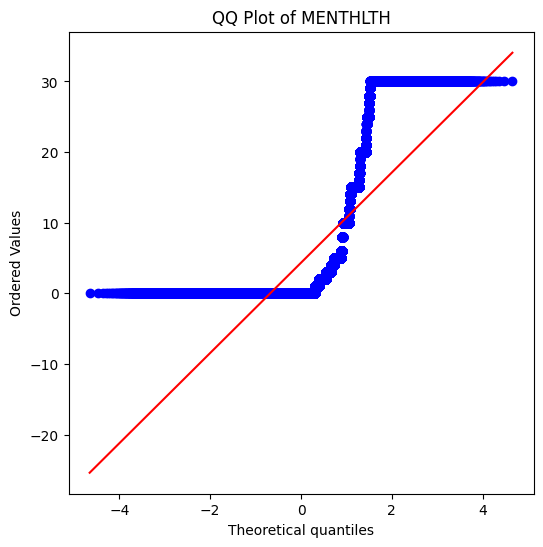

In [22]:
plt.figure(figsize=(6,6))
stats.probplot(df_clean["MENTHLTH"].dropna(), dist="norm", plot=plt)
plt.title("QQ Plot of MENTHLTH")
plt.show()

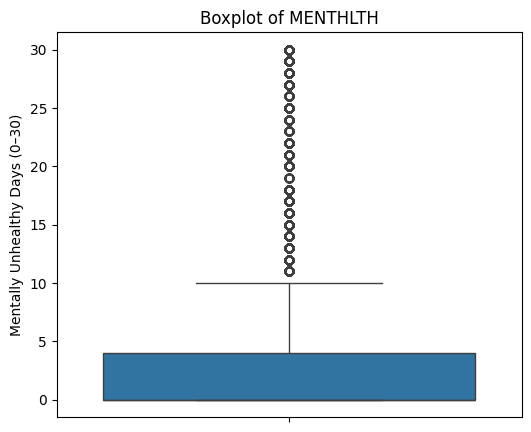

In [23]:
#Outlier Detection
plt.figure(figsize=(6,5))
sns.boxplot(y=df_clean["MENTHLTH"])
plt.title("Boxplot of MENTHLTH")
plt.ylabel("Mentally Unhealthy Days (0–30)")
plt.show()

In [24]:
q1 = df_clean["MENTHLTH"].quantile(0.25)
q3 = df_clean["MENTHLTH"].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 - 1.5 * iqr

outliers = df_clean[(df_clean["MENTHLTH"] < lower_bound) |
                    (df_clean["MENTHLTH"] > upper_bound)]

len(outliers)

427899

In [25]:
df_clean.groupby("INCOME3")["MENTHLTH"].mean()

,MENTHLTH
INCOME3,
1.0,9.092794
2.0,7.997893
3.0,6.867602
4.0,6.084384
5.0,5.391727
6.0,4.528787
8.0,3.530755
10.0,2.975644
11.0,2.641923


In [26]:
df_clean.groupby("EMPLOY1")["MENTHLTH"].mean()

,MENTHLTH
EMPLOY1,
1.0,4.326449
2.0,3.437265
3.0,8.159108
4.0,8.311114
5.0,4.358804
6.0,7.227641
8.0,11.027077


In [27]:
df_clean.groupby("EDUCA")["MENTHLTH"].mean().round(2)

,MENTHLTH
EDUCA,
1.0,4.15
2.0,4.64
3.0,6.37
4.0,4.87
5.0,4.95
6.0,3.44


In [28]:
df_clean.groupby("_HLTHPLN")["MENTHLTH"].mean()

,MENTHLTH
_HLTHPLN,
1.0,4.228725
2.0,5.971225


In [29]:
df_clean.groupby("MEDCOST1")["MENTHLTH"].mean()

,MENTHLTH
MEDCOST1,
1.0,10.269075
2.0,3.794615


In [30]:
df_clean.groupby("PERSDOC3")["MENTHLTH"].mean()

,MENTHLTH
PERSDOC3,
1.0,3.827120
2.0,4.867054
3.0,5.242271


In [31]:
df_clean.groupby("_RACEGR4")["MENTHLTH"].mean()

,MENTHLTH
_RACEGR4,
1.0,4.181013
2.0,4.608499
3.0,4.098472
4.0,6.676610
5.0,4.769015


In [32]:
df_clean.groupby("_AGEG5YR")["MENTHLTH"].mean()

,MENTHLTH
_AGEG5YR,
1.0,7.602341
2.0,6.721437
3.0,6.199706
4.0,5.632033
5.0,5.271145
6.0,4.982892
8.0,4.498556
10.0,3.174547
11.0,2.818862


In [37]:
df_clean.groupby("MARITAL")["MENTHLTH"].mean()

,MENTHLTH
MARITAL,
1.0,3.178445
2.0,5.508357
3.0,3.731309
4.0,7.499210
5.0,6.394672
6.0,6.339067


In [33]:
df_clean.groupby("SEXVAR")["MENTHLTH"].mean()

,MENTHLTH
SEXVAR,
1.0,3.619207
2.0,4.967447


In [34]:
df_clean.groupby("GENHLTH")["MENTHLTH"].mean()

,MENTHLTH
GENHLTH,
1.0,2.061880
2.0,2.893979
3.0,4.301573
4.0,7.987188
5.0,12.811714


In [35]:
df_clean.groupby("_AGEG5YR")["MENTHLTH"].mean()

,MENTHLTH
_AGEG5YR,
1.0,7.602341
2.0,6.721437
3.0,6.199706
4.0,5.632033
5.0,5.271145
6.0,4.982892
8.0,4.498556
10.0,3.174547
11.0,2.818862


In [36]:
df_clean.groupby("_RACEGR4")["MENTHLTH"].mean()

,MENTHLTH
_RACEGR4,
1.0,4.181013
2.0,4.608499
3.0,4.098472
4.0,6.676610
5.0,4.769015
